In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
train_dir = './archive2/fingers/train'
test_dir = './archive2/fingers/test'
img_height, img_width = 128, 128 
batch_size = 32

In [5]:
def extract_label(filename):
    return filename.split('_')[1][0]

In [6]:
def create_dataframe(directory):
    data = {'filename': [], 'label': []}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                filepath = os.path.join(root, file)
                label = extract_label(file)
                data['filename'].append(filepath)
                data['label'].append(label)
    return pd.DataFrame(data)

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    color_mode='grayscale'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

Found 14400 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.
Found 3600 validated image filenames belonging to 6 classes.


In [7]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.summary()

model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 


2024-05-26 03:45:06.555825: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-26 03:45:06.555862: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-26 03:45:06.555869: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-26 03:45:06.555932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-26 03:45:06.555959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
          

In [8]:
epochs = 30

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/30


2024-05-26 03:45:17.607201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


450/450 [==============================] - ETA: 0s - loss: 1.7916 - accuracy: 0.1663

2024-05-26 03:45:40.229761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


450/450 [==============================] - 25s 53ms/step - loss: 1.7916 - accuracy: 0.1663 - val_loss: 1.7895 - val_accuracy: 0.2168
Epoch 2/30
450/450 [==============================] - 24s 53ms/step - loss: 1.7875 - accuracy: 0.1918 - val_loss: 1.7853 - val_accuracy: 0.1931
Epoch 3/30
450/450 [==============================] - 23s 52ms/step - loss: 1.7828 - accuracy: 0.2099 - val_loss: 1.7807 - val_accuracy: 0.1956
Epoch 4/30
450/450 [==============================] - 24s 52ms/step - loss: 1.7780 - accuracy: 0.2142 - val_loss: 1.7753 - val_accuracy: 0.2045
Epoch 5/30
450/450 [==============================] - 24s 54ms/step - loss: 1.7720 - accuracy: 0.2331 - val_loss: 1.7685 - val_accuracy: 0.2282
Epoch 6/30
450/450 [==============================] - 24s 54ms/step - loss: 1.7644 - accuracy: 0.2482 - val_loss: 1.7595 - val_accuracy: 0.2475
Epoch 7/30
450/450 [==============================] - 24s 52ms/step - loss: 1.7535 - accuracy: 0.2699 - val_loss: 1.7471 - val_accuracy: 0.2525
Epo

In [10]:
model.save('finger_count_model.h5')

/Users/evgenijborisov/miniforge3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Точность на тестовых данных:', test_acc)

112/112 [==============================] - 2s 15ms/step - loss: 0.0710 - accuracy: 0.9768
Точность на тестовых данных: 0.9768415093421936


1/1 [==============================] - 0s 108ms/step


2024-05-26 04:21:03.357544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


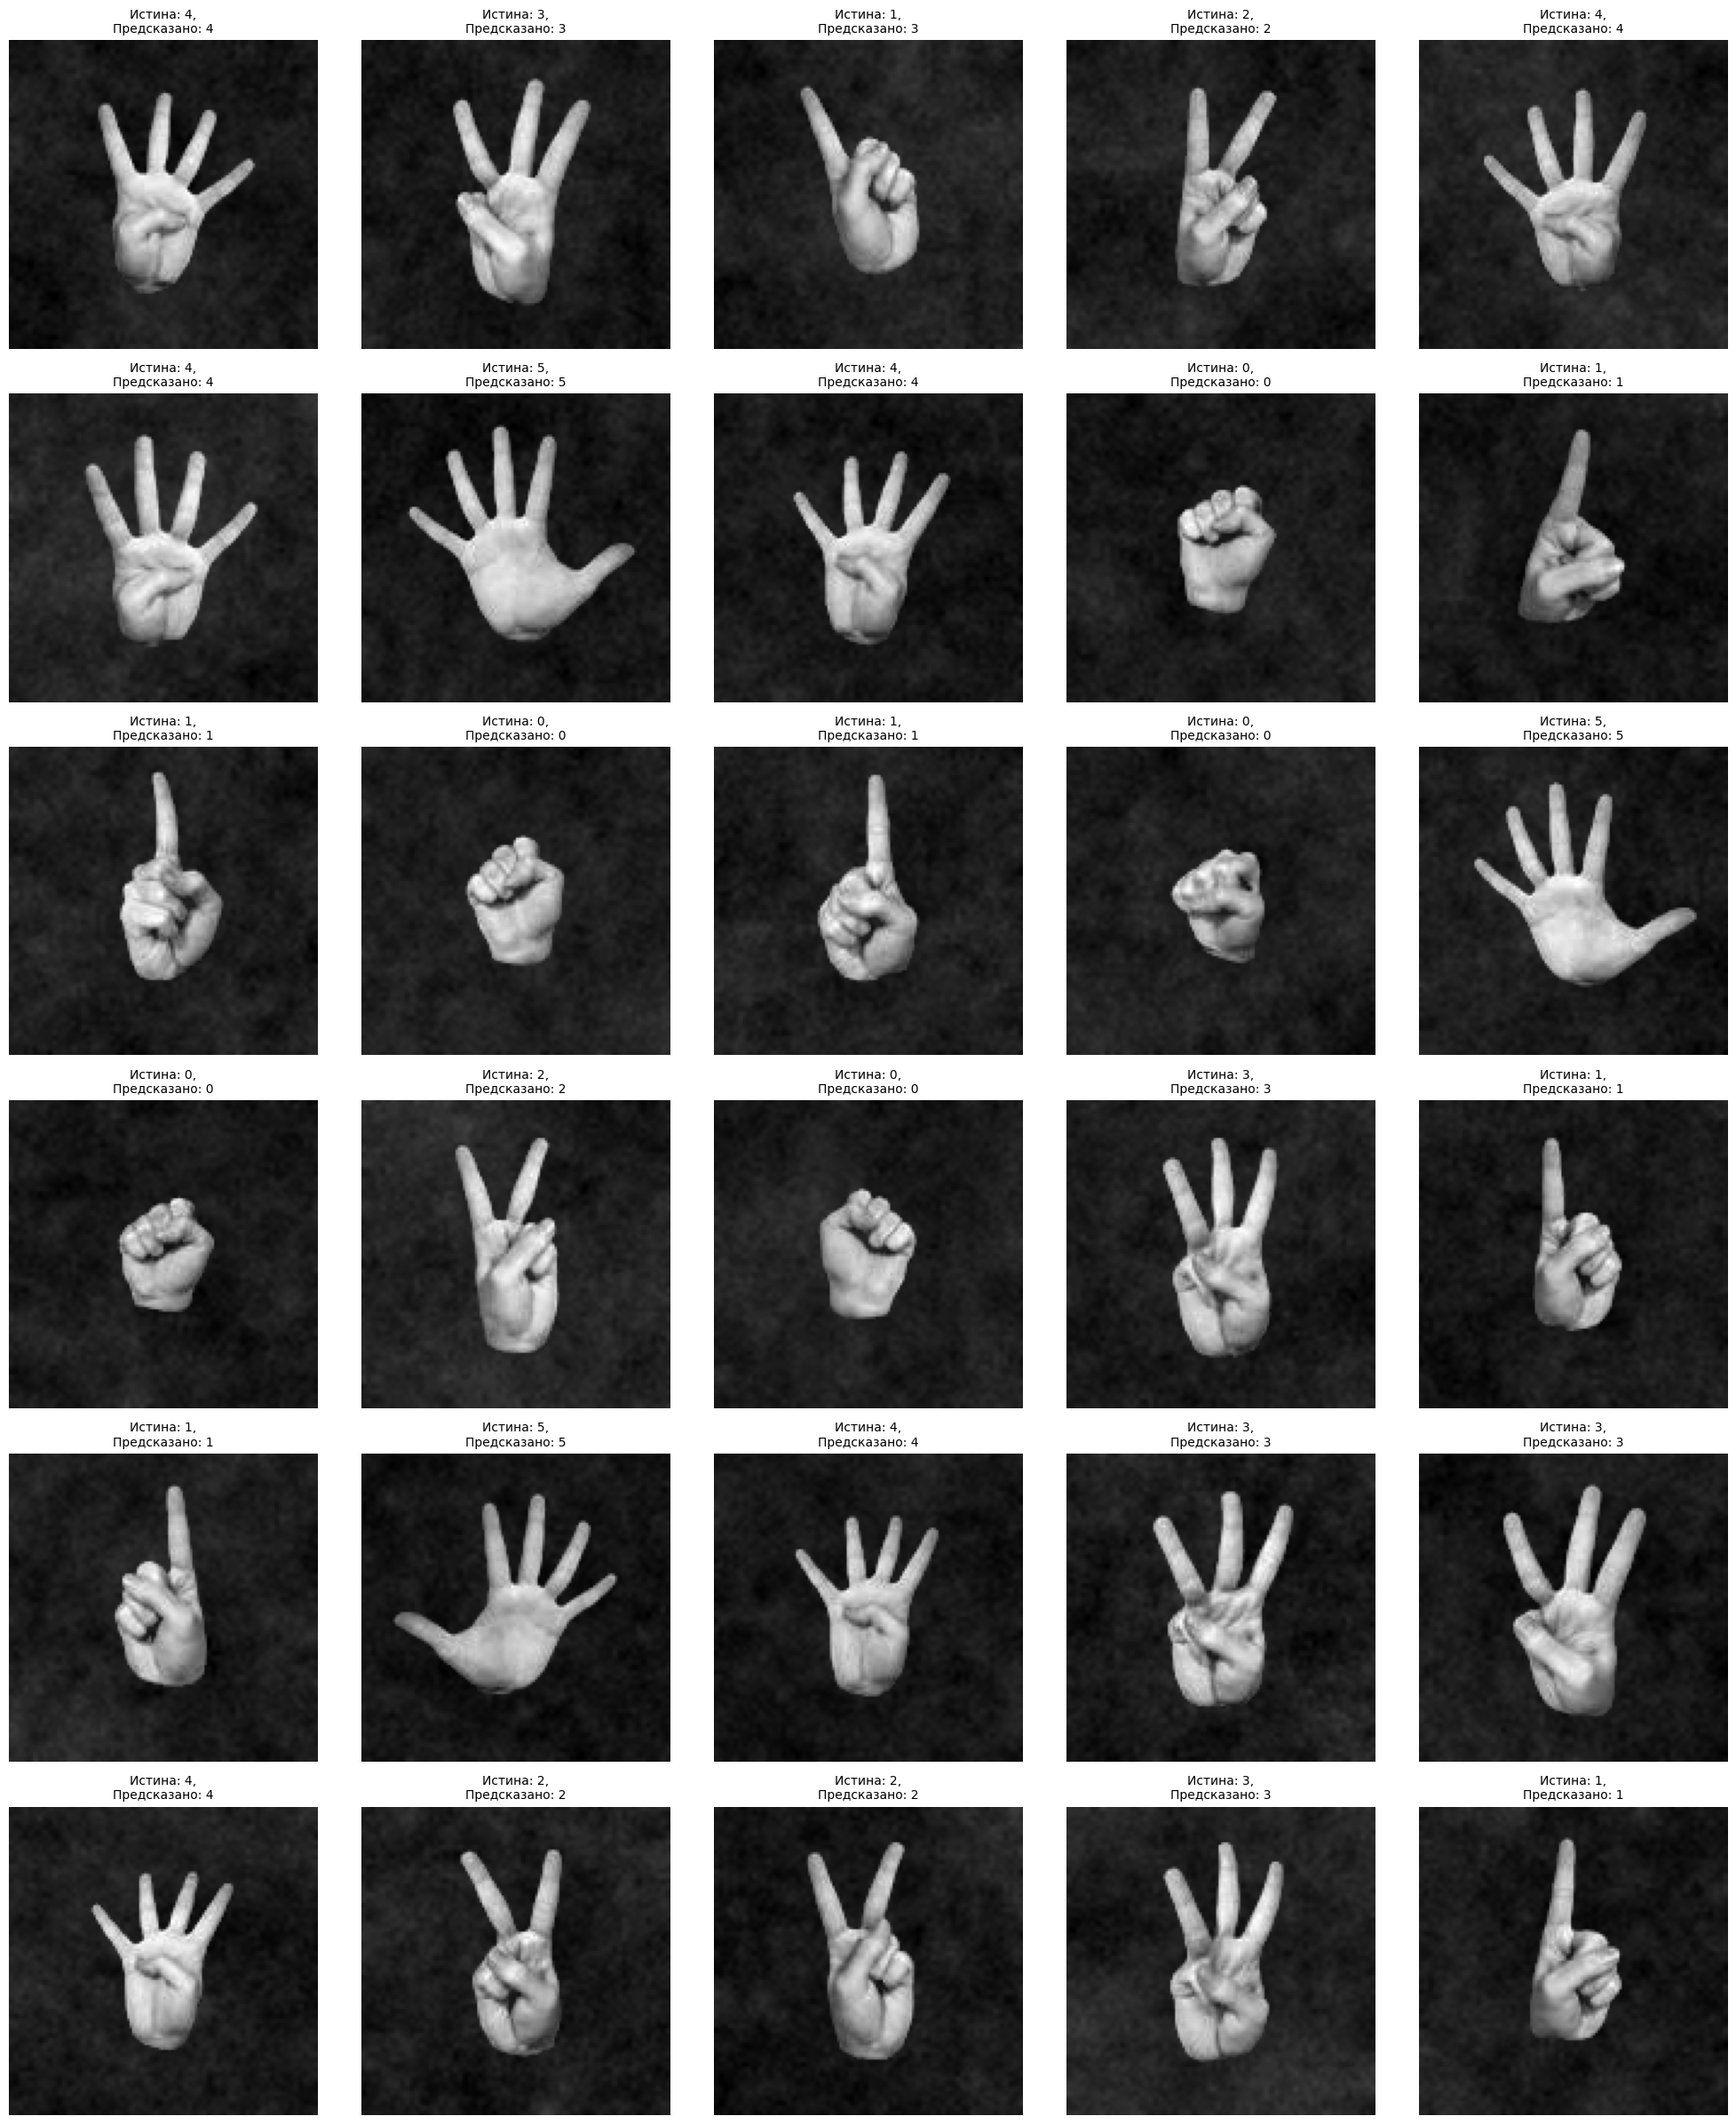

In [8]:
def plot_images_with_predictions(generator, model, num_images):
    images, labels = next(generator)
    predictions = model.predict(images)
    rows = (num_images // 5) + 1
    cols = 5
    
    plt.figure(figsize=(20, 4 * rows))
    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        real_class = np.argmax(labels[i])
        predicted_class = np.argmax(predictions[i])
        plt.title(f'Истина: {real_class},\nПредсказано: {predicted_class}', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

model = load_model('finger_count_model.h5')

plot_images_with_predictions(test_generator, model, 30)